<a href="https://colab.research.google.com/github/bghaendler/BJBS-AI-LAB/blob/master/BJBS_AI_Lab_Session_01_Skin_Cancer_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img width="300" src="https://raw.githubusercontent.com/bghaendler/BJBS-AI-LAB/master/img/BJBSAILogo.png" align="right"> 
# Session 1: Skin Cancer Detection

## Downloading the data from Kaggle

In [1]:
import os

!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000 # api copied from kaggle

100% 5.19G/5.20G [01:11<00:00, 79.5MB/s]
100% 5.20G/5.20G [01:11<00:00, 77.6MB/s]


In [0]:
import zipfile
with zipfile.ZipFile("/content/skin-cancer-mnist-ham10000.zip","r") as zip_ref:
    zip_ref.extractall("input")

1. Skin Cancer Detector
 1. https://www.kaggle.com/vbookshelf/skin-lesion-analyzer-tensorflow-js-web-app
 2. https://www.kaggle.com/ingbiodanielh/skin-cancer-classification-with-resnet-50-fastai

## Libraries

We import all the necessary packages. We are going to work with the fastai V1 library which sits on top of Pytorch 1.0. The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [0]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.metrics import error_rate
from glob import glob

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc,roc_curve

In [4]:
import os
print(os.listdir("input"))

['hmnist_28_28_L.csv', 'hmnist_8_8_L.csv', 'hmnist_28_28_RGB.csv', 'ham10000_images_part_2', 'hmnist_8_8_RGB.csv', 'HAM10000_images_part_1', 'ham10000_images_part_1', 'HAM10000_metadata.csv', 'HAM10000_images_part_2']


## Exploratory Data Analysis

<img width="800" src="https://image.ibb.co/n8PBkL/cover.png">


- Training of neural networks for automated diagnosis of pigmented skin lesions is hampered by the small size and lack of diversity of available dataset of dermatoscopic images. 
- We tackle this problem by releasing the HAM10000 ("Human Against Machine with 10000 training images") dataset. 
- We collected dermatoscopic images from different populations, acquired and stored by different modalities. 
- The final dataset consists of 10015 dermatoscopic images which can serve as a training set for academic machine learning purposes. 
- Cases include a representative collection of all important diagnostic categories in the realm of pigmented lesions: 
 - Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec), 
 - basal cell carcinoma (bcc), 
 - benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl), 
 - dermatofibroma (df), 
 - melanoma (mel), 
 - melanocytic nevi (nv) and 
 - vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc).

- More than 50% of lesions are confirmed through histopathology (histo), 
 - the ground truth for the rest of the cases is either 
  - follow-up examination (follow_up), 
  - expert consensus (consensus), or 
  - confirmation by in-vivo confocal microscopy (confocal). 
- The dataset includes lesions with multiple images, which can be tracked by the lesion_id-column within the HAM10000_metadata file.
<img width="500px" src="http://www.justscience.in/wp-content/uploads/2017/12/what-causes-skin-cancer.jpg">

In [0]:
image_dir = "input"

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(image_dir, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [6]:
image_dataframe = pd.read_csv(os.path.join('input/', 'HAM10000_metadata.csv'))
image_dataframe.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization
2834,HAM_0003826,ISIC_0026433,bcc,histo,70.0,male,chest
5675,HAM_0007200,ISIC_0026304,nv,follow_up,50.0,male,back
3425,HAM_0001918,ISIC_0031291,nv,follow_up,45.0,female,back
2588,HAM_0003186,ISIC_0027297,bcc,histo,70.0,male,face
7782,HAM_0007494,ISIC_0033136,nv,histo,25.0,female,face


In [7]:
image_dataframe['path'] = image_dataframe['image_id'].map(imageid_path_dict.get)
image_dataframe['cell_type'] = image_dataframe['dx'].map(lesion_type_dict.get) 
image_dataframe['cell_type_idx'] = pd.Categorical(image_dataframe['cell_type']).codes
image_dataframe.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,input/ham10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,input/ham10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,input/ham10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,input/ham10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,input/HAM10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2


In [8]:
print(image_dataframe.cell_type.value_counts())

Melanocytic nevi                  6705
dermatofibroma                    1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: cell_type, dtype: int64


## Plot

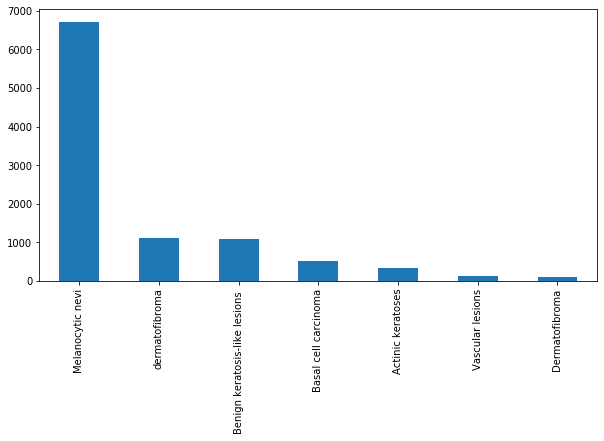

In [9]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
image_dataframe['cell_type'].value_counts().plot(kind='bar', ax=ax1)

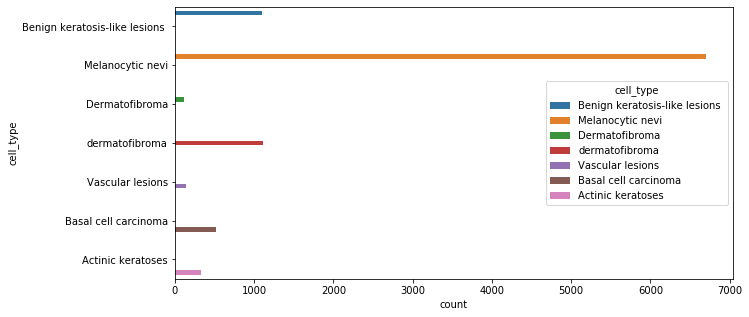

In [10]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
sns.countplot(y='cell_type',data=image_dataframe, hue="cell_type",ax=ax1)




Here we notice tha we have data imbalance

In [11]:
image_dataset = pd.concat([image_dataframe['path'], image_dataframe['cell_type']], axis=1, keys=['name', 'label'])

image_dataset.head(5)

,name,label
0,input/ham10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions
1,input/ham10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions
2,input/ham10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions
3,input/ham10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions
4,input/HAM10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions


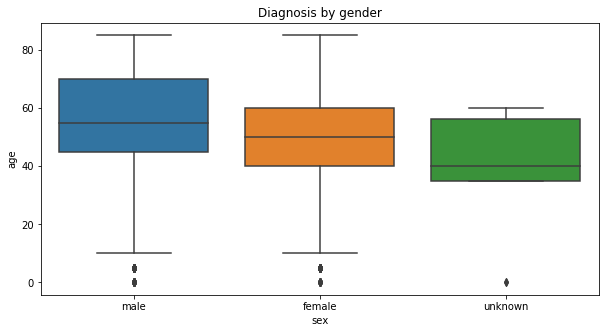

In [12]:
f, ax1 = plt.subplots(1,1, figsize=(10,5))
sns.boxplot(
    x=image_dataframe['sex'], 
    y=image_dataframe['age'], 
    #hue=image_dataframe['sex'], 
    ax=ax1)
plt.title('Diagnosis by gender')
plt.show()

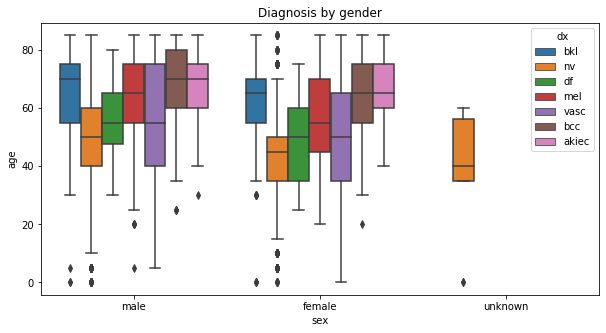

In [13]:
f, ax1 = plt.subplots(1,1, figsize=(10,5))
sns.boxplot(x=image_dataframe['sex'], y=image_dataframe['age'], hue=image_dataframe['dx'], ax=ax1)
plt.title('Diagnosis by gender')
plt.show()

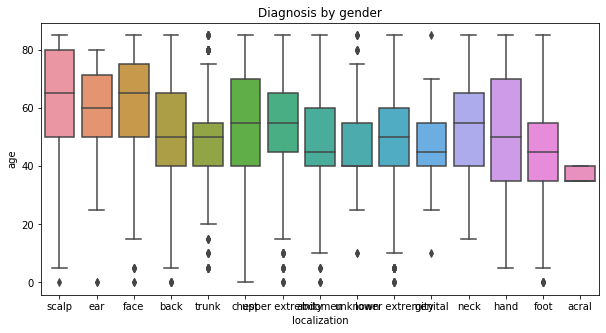

In [14]:
f, ax1 = plt.subplots(1,1, figsize=(10,5))
sns.boxplot(x=image_dataframe['localization'], y=image_dataframe['age'], ax=ax1)
plt.title('Diagnosis by gender')
plt.show()

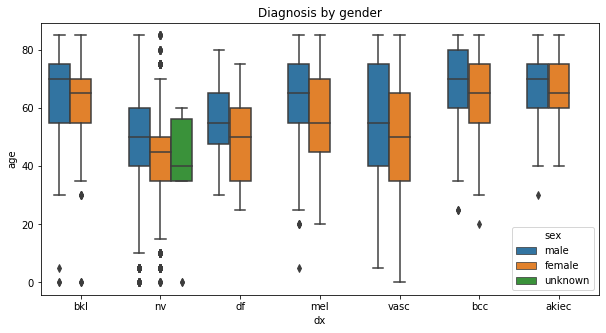

In [15]:
f, ax1 = plt.subplots(1,1, figsize=(10,5))
sns.boxplot(x=image_dataframe['dx'], y=image_dataframe['age'], hue=image_dataframe['sex'], ax=ax1)
plt.title('Diagnosis by gender')
plt.show()

In [0]:
bs = 64

tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_df(".", image_dataset, ds_tfms=tfms, size=28, bs=bs).normalize(imagenet_stats)

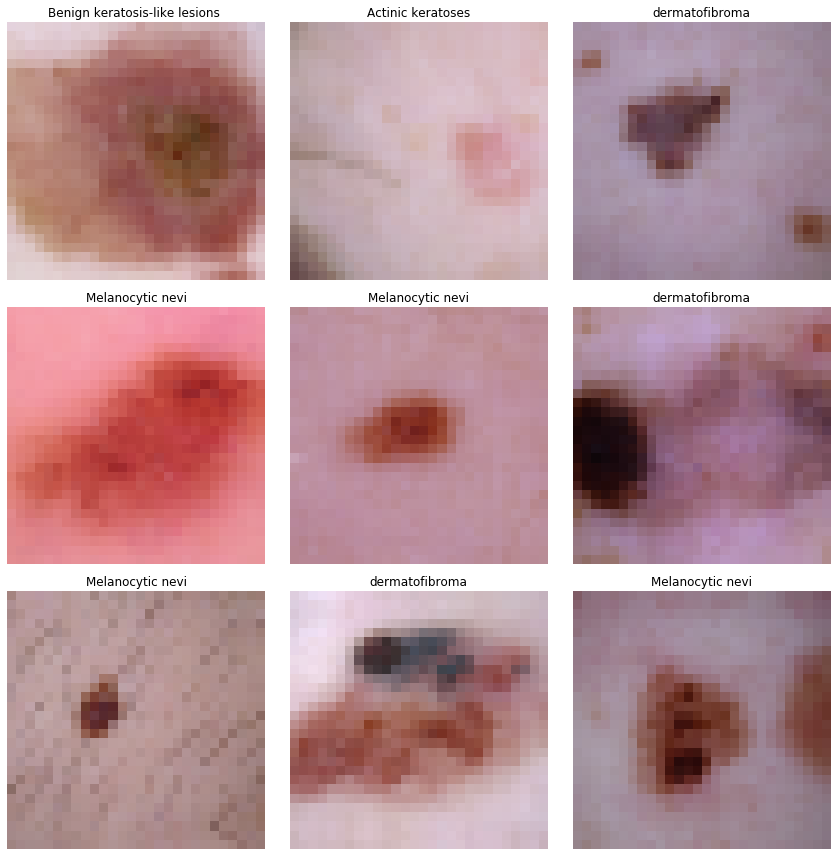

In [17]:
data.show_batch(rows=3, figsize=(12,12))

## Model Resnet 50

- Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the resnet paper).

<img width="900" src="https://i.stack.imgur.com/gI4zT.png">

https://arxiv.org/pdf/1512.03385.pdf

- Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [18]:
learner=create_cnn(data,models.resnet50,metrics=[accuracy], model_dir="/tmp/model/")

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [0]:
#learner.model

In [0]:
learner.loss_func=nn.CrossEntropyLoss()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


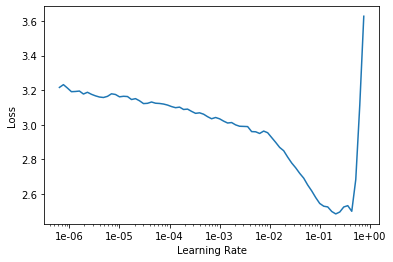

In [21]:
learner.lr_find()
learner.recorder.plot()

In [22]:
learner.fit_one_cycle(10, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.184469,1.591658,0.591113,04:28
1,1.293537,0.852202,0.721418,04:29
2,0.896790,0.724674,0.743884,04:30
3,0.795079,0.685139,0.755866,04:29
4,0.730610,0.680030,0.761358,04:30
5,0.708871,0.620983,0.776335,04:28
6,0.660156,0.629099,0.776335,04:27
7,0.640846,0.615372,0.782826,04:27
8,0.603497,0.603500,0.784324,04:26
9,0.600594,0.601409,0.785322,04:29


In [0]:
learner.unfreeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


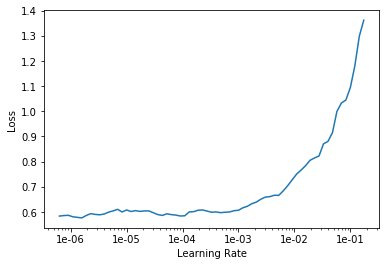

In [24]:
learner.lr_find()
learner.recorder.plot()

In [25]:
hhlr=1e-6
learner.fit_one_cycle(10, slice(3*lr,10*lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.598278,0.601659,0.781827,06:04
1,0.598382,0.602830,0.782826,06:04
2,0.597681,0.594052,0.788817,06:06
3,0.594235,0.592725,0.785322,06:10
4,0.574604,0.588350,0.789316,06:17
5,0.576153,0.584819,0.790814,06:15
6,0.551806,0.585444,0.789316,06:15
7,0.550358,0.588762,0.790814,06:14
8,0.543088,0.585403,0.787319,06:20
9,0.551631,0.586694,0.785821,06:21


In [0]:
learner.save('stage-1')

In [41]:
interp = ClassificationInterpretation.from_learner(learner)

In [42]:


losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

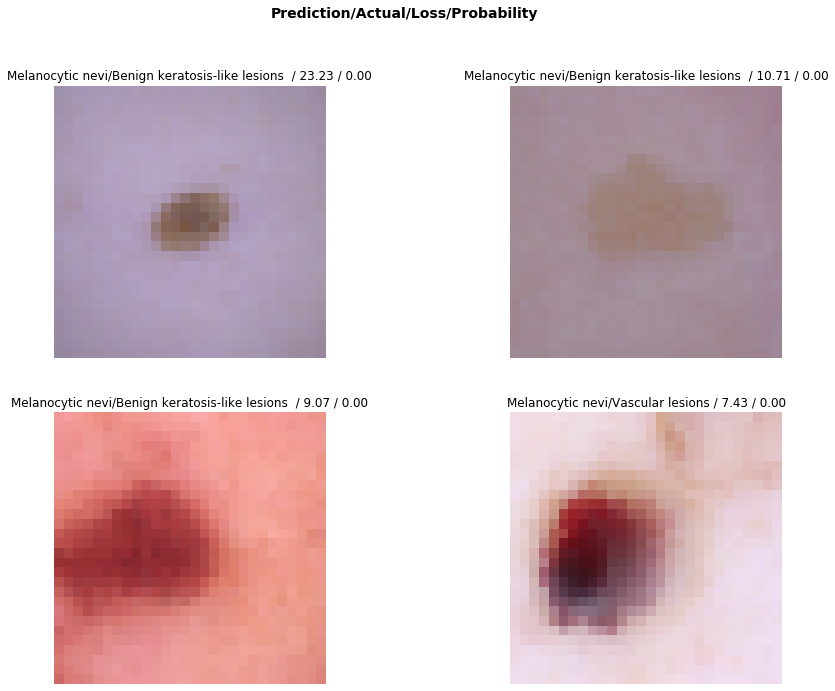

In [43]:
interp.plot_top_losses(4, figsize=(15,11))

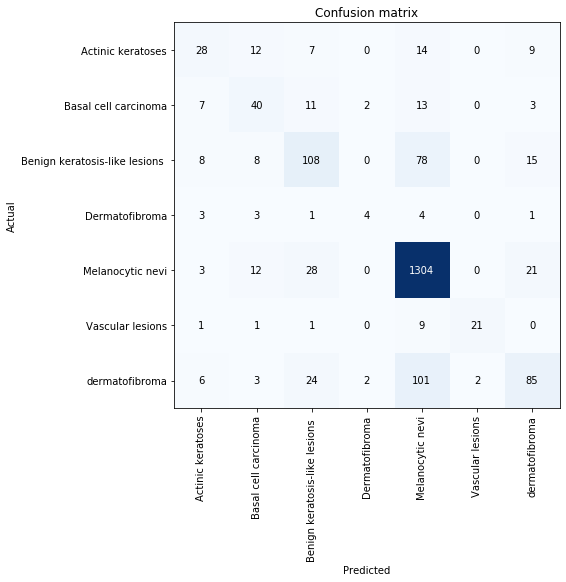

In [44]:
interp.plot_confusion_matrix(figsize=(10,8))

In [45]:

interp.most_confused(min_val=19)

[('dermatofibroma', 'Melanocytic nevi', 101),
 ('Benign keratosis-like lesions ', 'Melanocytic nevi', 78),
 ('Melanocytic nevi', 'Benign keratosis-like lesions ', 28),
 ('dermatofibroma', 'Benign keratosis-like lesions ', 24),
 ('Melanocytic nevi', 'dermatofibroma', 21)]

# Unfreeze

In [0]:

learner.unfreeze()

In [47]:
learner.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.713477,0.637022,0.771343,06:14


In [0]:
learner.load('stage-1');

In [48]:

learner.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


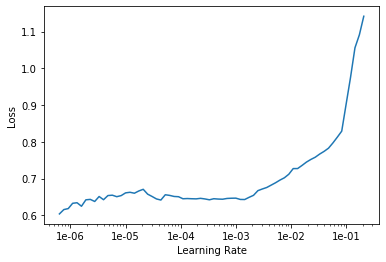

In [49]:

learner.recorder.plot()

In [50]:
learner.unfreeze()
learner.fit_one_cycle(12, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.651260,0.622668,0.775337,06:08
1,0.639360,0.592865,0.791812,06:08
2,0.602414,0.577667,0.790315,06:04
3,0.583524,0.565835,0.788318,06:06
4,0.570742,0.560566,0.788817,06:09
5,0.549340,0.560362,0.789316,06:05
6,0.526281,0.562641,0.794808,06:05
7,0.521275,0.561590,0.797304,06:05
8,0.504029,0.559825,0.796306,06:08
9,0.500624,0.559403,0.795307,06:09


## Predictions

In [51]:
# Predictions of the validation data
preds_val, y_val=learner.get_preds()

In [52]:
predictor = create_cnn(pred_data, models.resnet50, model_dir="/tmp/model/").load('stage-1')

NameError: ignored

### Roc Curve
With the ROC curve we will mesuare how good it's our model

- A receiver operating characteristic curve, or ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. 
- The ROC curve is created by plotting the true positive rate against the false positive rate at various threshold settings.
<img width="800" src="https://st3.ning.com/topology/rest/1.0/file/get/1341805045?profile=original">

- With a ROC curve, you're trying to find a good model that optimizes the trade off between the False Positive Rate (FPR) and True Positive Rate (TPR).  
- What counts here is how much area is under the curve (Area under the Curve = AuC). 
- The ideal curve in the left image fills in 100%, which means that you're going to be able to distinguish between negative results and positive results 100% of the time (which is almost impossible in real life). 
- The further you go to the right, the worse the detection. 
- The ROC curve to the far right does a worse job than chance, mixing up the negatives and positives (which means you likely have an error in your setup).

In [53]:
#  ROC curve
fpr, tpr, thresholds = roc_curve(y_val.numpy(), preds_val.numpy()[:,1], pos_label=1)

#  ROC area
pred_score = auc(fpr, tpr)
print(f'ROC area is {pred_score}')

ROC area is 0.9623904077786578


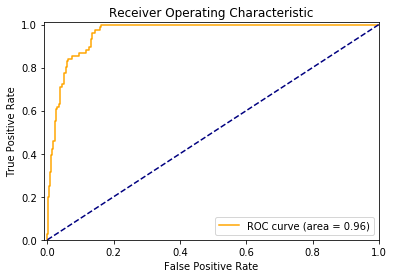

In [54]:
plt.figure()
plt.plot(fpr, tpr, color='orange', label='ROC curve (area = %0.2f)' % pred_score)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Prediction

In [55]:
learner.to_fp32()   #I think that in latest version of fastai you don't have to come back 
                    #from half_precision, but here gives me an error when running TTA.
int=learner.interpret(tta=True)

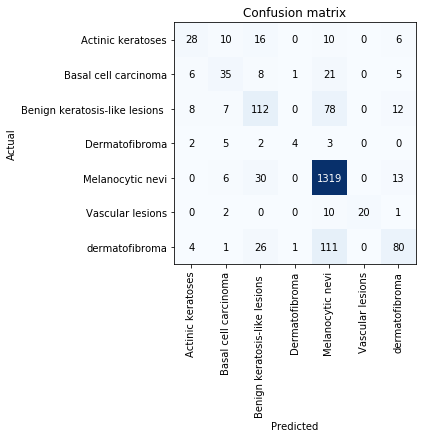

In [56]:
int.plot_confusion_matrix(figsize=(6,6))

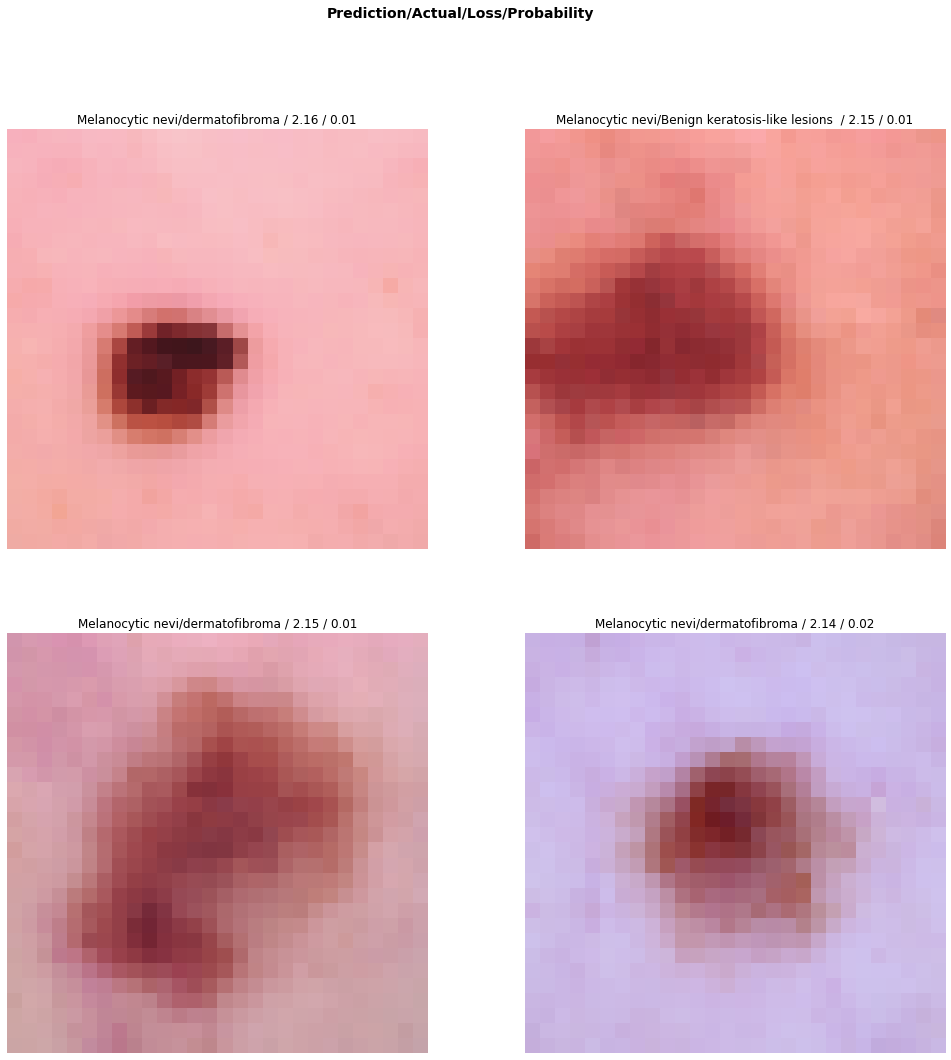

In [57]:
int.plot_top_losses(4, figsize=(17,17), heatmap=True)